In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
import math
sys.path.append("..")
from basic_tools import *
print(torch.cuda.is_available())

True


In [2]:
def conv3x3(in_planes, out_planes, stride=1, groups=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, groups=groups, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [3]:
class SEModule(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.avg_pool(input)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return input * x

In [27]:
class Res2NetBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, downsample=None, stride=1, scales=4, groups=1, se=False,  norm_layer=None,
                reduction = 16,):
        global _mapper_x, _mapper_y
        super(Res2NetBottleneck, self).__init__()
        if planes % scales != 0:
            raise ValueError('Planes must be divisible by scales')
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        bottleneck_planes = groups * planes
        c2wh = dict([(144, 32), (288, 16), (576, 8)])
        self.planes = planes
        self.conv1 = conv1x1(inplanes, bottleneck_planes, stride)
        self.bn1 = norm_layer(bottleneck_planes)
        self.conv2 = nn.ModuleList([conv3x3(bottleneck_planes // scales, bottleneck_planes // scales, groups=groups) for _ in range(scales-1)])
        self.bn2 = nn.ModuleList([norm_layer(bottleneck_planes // scales) for _ in range(scales-1)])
        self.conv3 = conv1x1(bottleneck_planes, planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.bn3 = norm_layer(planes * self.expansion)
        self.se = SEModule(planes * self.expansion) if se else None
        self.downsample = downsample
        self.stride = stride
        self.scales = scales

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        xs = torch.chunk(out, self.scales, 1)
        ys = []
        sum_y = []
        for s in range(self.scales):
            if s == 0:
                ys.append(xs[s])
                sum_y.append(ys[-1])
            else:
                ys.append(self.relu(self.bn2[s-1](self.conv2[s-1](xs[s] + sum_y[-1]))))
                sum_y.append(sum_y[-1] + self.conv2[s-1](xs[s] + sum_y[-1]))
        out = torch.cat(ys, 1)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.se is not None:
            out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = self.relu(out)

        return out

In [28]:
class Res2Net(nn.Module):
    def __init__(self, layers, num_classes=100, zero_init_residual=False,
                 groups=1, width=64, scales=4, se=False, norm_layer=None):
        super(Res2Net, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        planes = [int(width * scales * 2 ** i) for i in range(3)]
        self.inplanes = planes[0]
        self.conv1 = conv3x3(3, planes[0])
        self.bn1 = norm_layer(planes[0])
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(Res2NetBottleneck, planes[0], layers[0], scales=scales, groups=groups, se=se, norm_layer=norm_layer)
        self.layer2 = self._make_layer(Res2NetBottleneck, planes[1], layers[1], stride=2, scales=scales, groups=groups, se=se, norm_layer=norm_layer)
        self.layer3 = self._make_layer(Res2NetBottleneck, planes[2], layers[2], stride=2, scales=scales, groups=groups, se=se, norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(planes[2] * Res2NetBottleneck.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Res2NetBottleneck):
                    nn.init.constant_(m.bn3.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, scales=4, groups=1, se=False, norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, downsample, stride=stride, scales=scales, groups=groups, se=se, norm_layer=norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, scales=scales, groups=groups, se=se, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate=0.01
momentum=0.9
weight_decay=0.0001
batch_size=56
epochs=100
data_path='../data'
model_name='Res22DenseNet'+'epoch='+str(epochs)
print(device)
model=Res2Net([3, 3, 3], groups=6, width=24, scales=6, se=True).to(device)
criterion=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

cuda:0


In [48]:
trainloader,testloader=get_data_loaders(train_batch_size=batch_size,test_batch_size=batch_size,data_path=data_path)

In [ ]:
for epoch in range(epochs):
    train_loss,train_acc,train_top5_acc=train(model,trainloader,criterion,optimizer,device)
    print('epoch:{},'.format(epoch))
    test_loss,test_acc,test_top5_acc=test(model,testloader,criterion,device)
    print('train_loss:{:.4f},train_acc:{:.4f},train_top5_acc:{:.4f},test_loss:{:.4f},test_acc:{:.4f},test_top5_acc:{:.4f}'.format(train_loss,train_acc,train_top5_acc,test_loss,test_acc,test_top5_acc))
    torch.save(model.state_dict(), model_name+'.pth')
    train_lossa.append(train_loss)
    test_lossa.append(test_loss)
    train_acca.append(train_acc)
    test_acca.append(test_acc)
    train_top5_acca.append(train_top5_acc)
    test_top5_acca.append(test_top5_acc)

#画图
save_plots(train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca,model_name)
save_log(model_name,train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca)

epoch:0,
train_loss:0.0334,train_acc:99.0940,train_top5_acc:99.9780,test_loss:0.9597,test_acc:78.4300,test_top5_acc:94.4800
epoch:1,
train_loss:0.0090,train_acc:99.8580,train_top5_acc:100.0000,test_loss:0.9311,test_acc:79.1900,test_top5_acc:94.7900
epoch:2,
train_loss:0.0068,train_acc:99.9000,train_top5_acc:100.0000,test_loss:0.9183,test_acc:79.4400,test_top5_acc:94.8300
epoch:3,
train_loss:0.0050,train_acc:99.9300,train_top5_acc:100.0000,test_loss:0.9202,test_acc:79.3100,test_top5_acc:94.6900
epoch:4,
train_loss:0.0045,train_acc:99.9380,train_top5_acc:100.0000,test_loss:0.9030,test_acc:79.6300,test_top5_acc:94.8100
epoch:5,
train_loss:0.0040,train_acc:99.9500,train_top5_acc:100.0000,test_loss:0.8914,test_acc:79.5600,test_top5_acc:94.7700
epoch:6,
train_loss:0.0040,train_acc:99.9340,train_top5_acc:100.0000,test_loss:0.8827,test_acc:79.7200,test_top5_acc:94.9100
epoch:7,
train_loss:0.0038,train_acc:99.9340,train_top5_acc:100.0000,test_loss:0.8775,test_acc:79.8200,test_top5_acc:95.0200
e

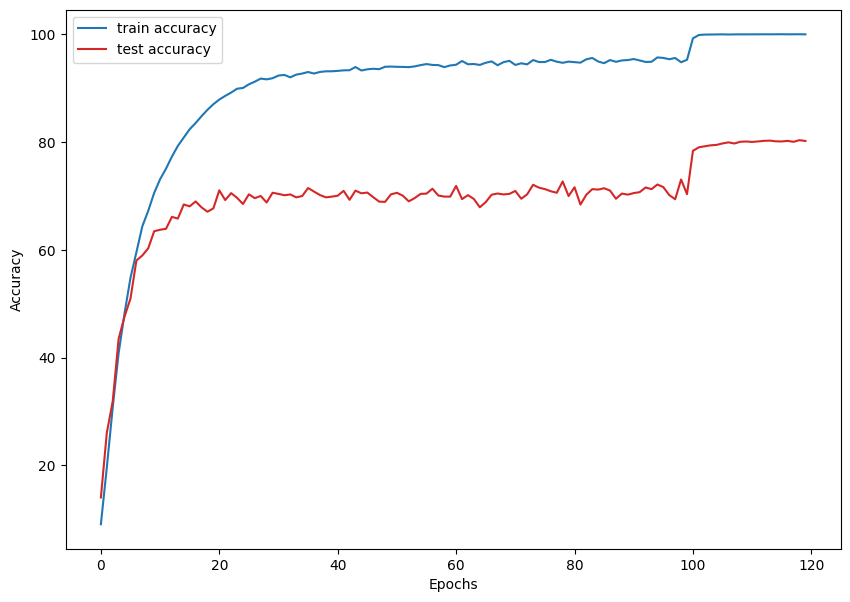

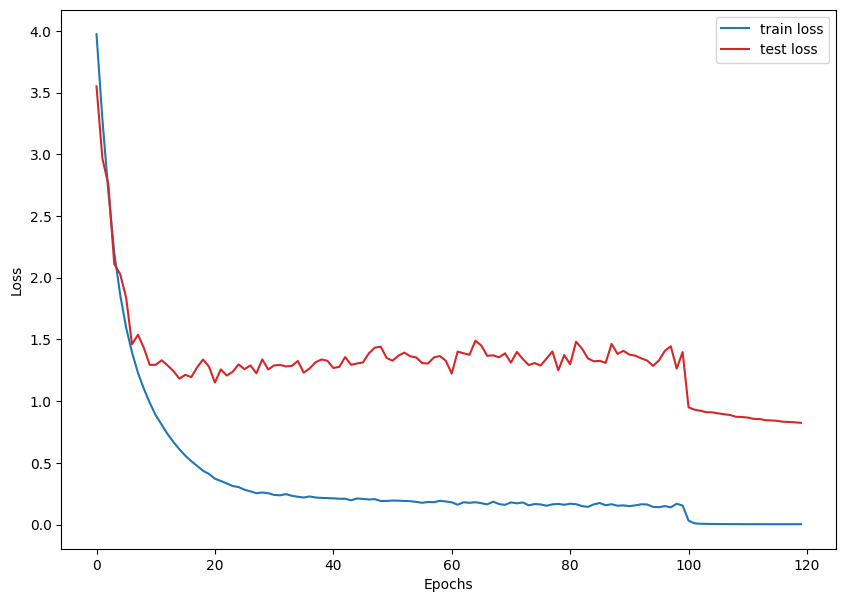

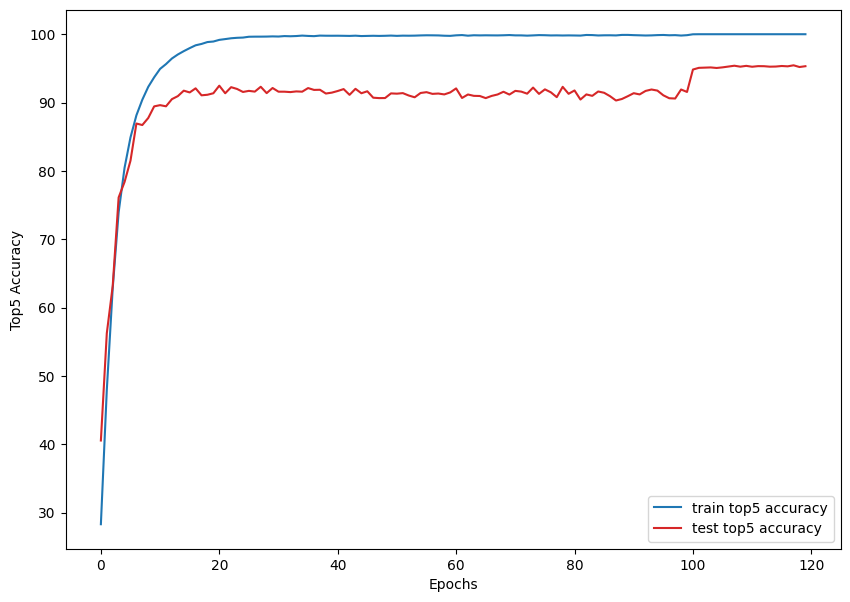

In [18]:
save_plots(train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca,model_name)
save_log(model_name,train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca)

In [49]:
modelpath='./'
model_last_name='Res22DenseNetepoch=100'
model.load_state_dict(torch.load(modelpath+model_last_name+'.pth'))

<All keys matched successfully>